# Backpack Prediction Challenge | CatBoost

Code by Hanbo Shim

## Contents
- EDA
- Train-test Split
- Train data preprocessing
- CatBoost Model Fitting
- Test data preprocessing
- Model prediction

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [2]:
# Ignore deprecation warning from now on
import warnings
warnings.filterwarnings('ignore')

# EDA

Viewing the first 5 rows of the dataset.

In [3]:
full_data=pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
full_data.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


## Visualization of data distribution

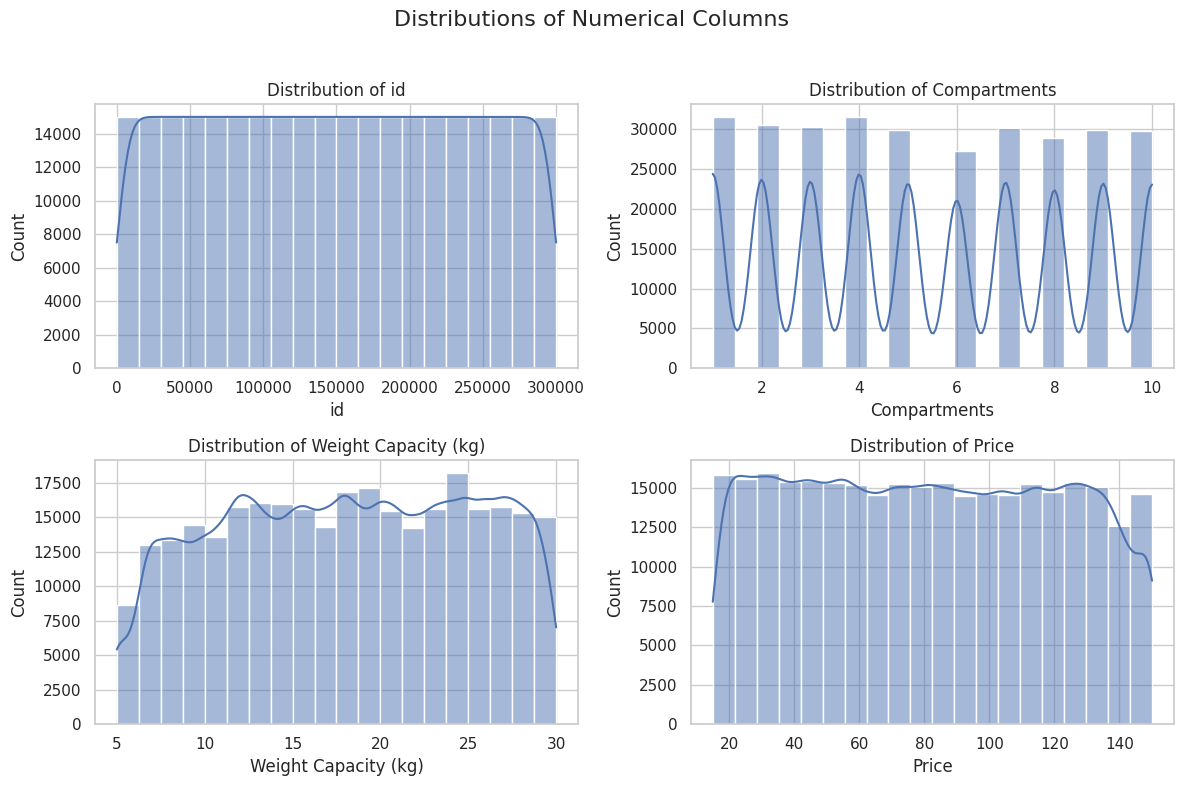

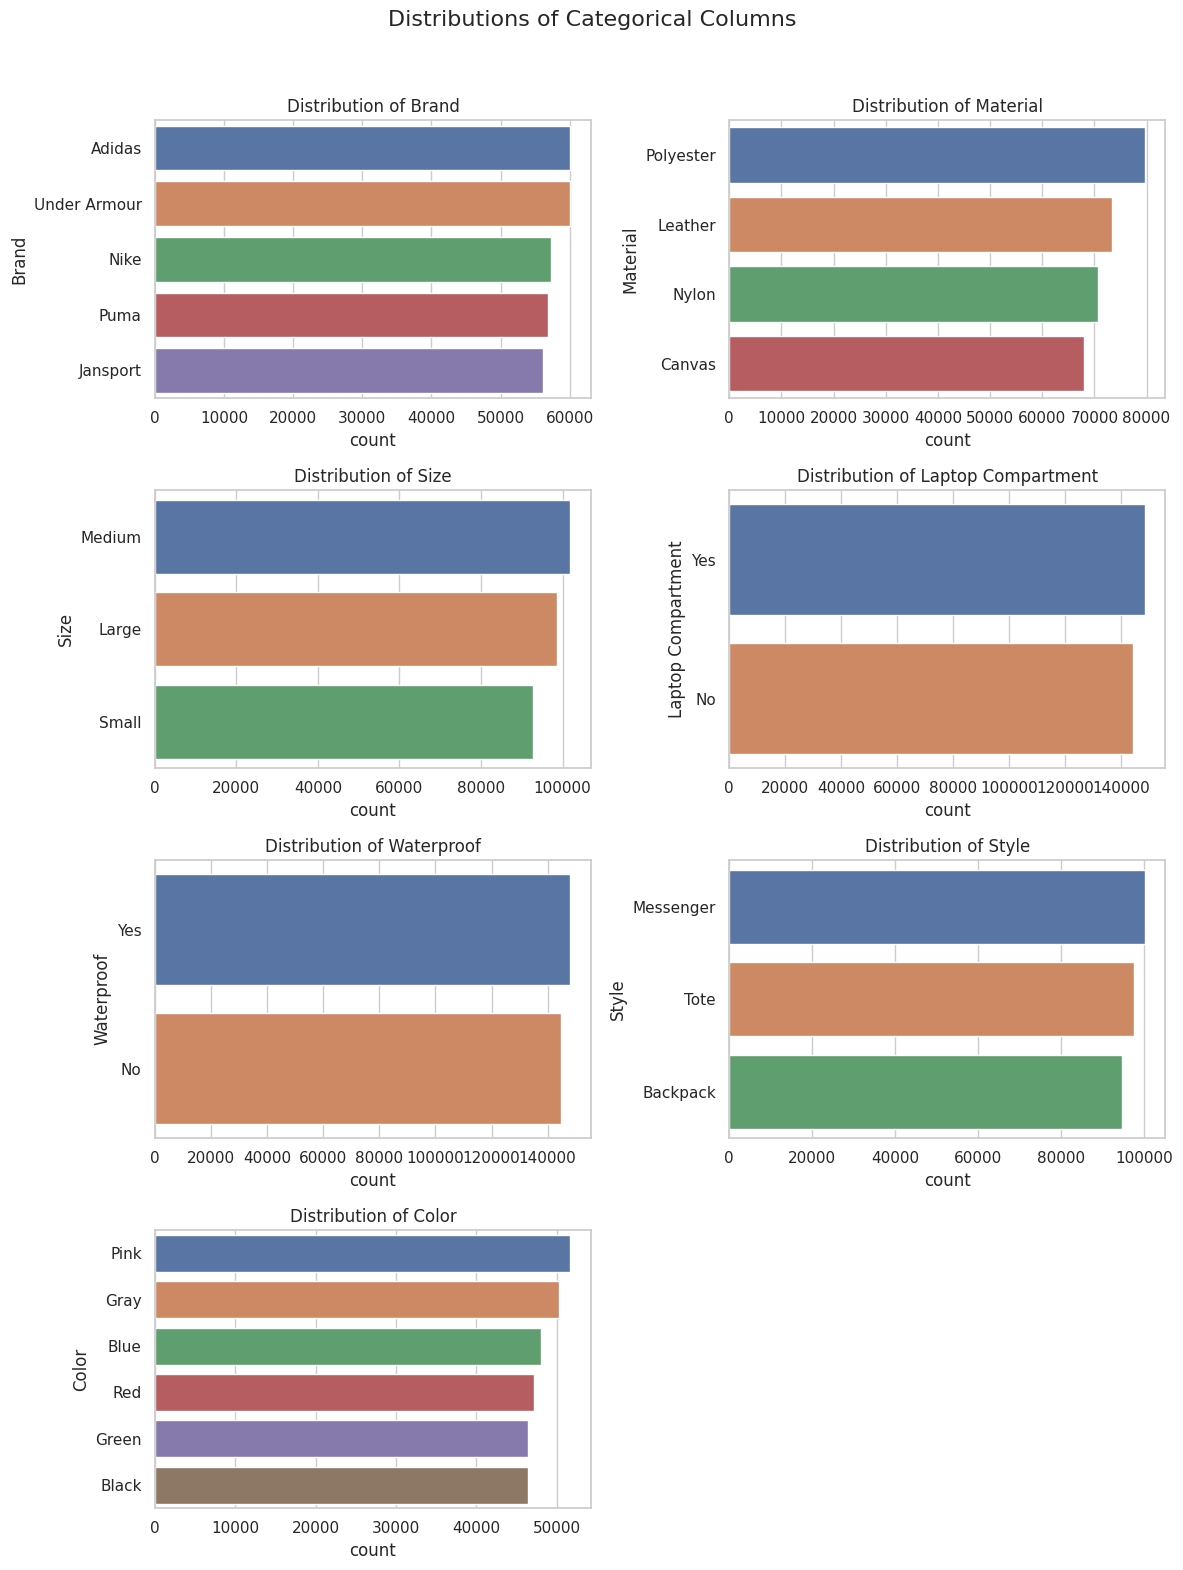

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Load the dataset (update the filename as needed)
df = full_data

# Set up the plotting style
sns.set(style="whitegrid")

# Plot numerical columns
num_cols = df.select_dtypes(include=["number"]).columns
num_rows = math.ceil(len(num_cols) / 2)  # Arrange in two columns

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
fig.suptitle("Distributions of Numerical Columns", fontsize=16)

for i, col in enumerate(num_cols):
    row, col_idx = divmod(i, 2)
    sns.histplot(df[col], kde=True, bins=20, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f"Distribution of {col}")

# Hide empty subplots if odd number of numerical columns
if len(num_cols) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
plt.show()

# Plot categorical columns
cat_cols = df.select_dtypes(exclude=["number"]).columns
num_rows = math.ceil(len(cat_cols) / 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
fig.suptitle("Distributions of Categorical Columns", fontsize=16)

for i, col in enumerate(cat_cols):
    row, col_idx = divmod(i, 2)
    sns.countplot(y=df[col], order=df[col].value_counts().index, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f"Distribution of {col}")

# Hide empty subplots if odd number of categorical columns
if len(cat_cols) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Data analysis

There are compartment, capacity, and price as a numerical variables and Brand, Material, Size, Laptop Compartment, Waterproof, Style and Color as a categorical variables. In the analysis below, there are NaN entries for each categorical variables.

In [5]:
for cols in full_data:
    if full_data.loc[:, cols].dtype=='object':
        print(cols, full_data.loc[:,cols].unique())

Brand ['Jansport' 'Under Armour' 'Nike' 'Adidas' 'Puma' nan]
Material ['Leather' 'Canvas' 'Nylon' nan 'Polyester']
Size ['Medium' 'Small' 'Large' nan]
Laptop Compartment ['Yes' 'No' nan]
Waterproof ['No' 'Yes' nan]
Style ['Tote' 'Messenger' nan 'Backpack']
Color ['Black' 'Green' 'Red' 'Blue' 'Gray' 'Pink' nan]


# Train-test split

Before preprocessing, train-test split is required to prevent data leakage. Full data is divided in to data X and label y.

In [6]:
X = full_data.loc[:, full_data.columns != 'Price']
y = full_data.loc[:, full_data.columns == 'Price']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.3)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
print("Split Done")

(210000, 10) (210000, 1) (90000, 10) (90000, 1)
Split Done


# Data Preprocessing

Identifying the number of missing entries for each columns.

In [8]:
for col in X_train.columns:
    ratio=X_train.loc[:, col].isna().sum()*100/X_train.loc[:, col].shape[0]
    print(f"{col} | {ratio:.2f}% missing ({X_train.loc[:, col].isna().sum()} missing)")

id | 0.00% missing (0 missing)
Brand | 3.21% missing (6747 missing)
Material | 2.77% missing (5824 missing)
Size | 2.19% missing (4605 missing)
Compartments | 0.00% missing (0 missing)
Laptop Compartment | 2.48% missing (5210 missing)
Waterproof | 2.34% missing (4915 missing)
Style | 2.64% missing (5547 missing)
Color | 3.28% missing (6883 missing)
Weight Capacity (kg) | 0.04% missing (93 missing)


All columns has missing values less than 5%, so imputation is appropriate

Among numerical variables, only weight capacity has missing value. Since it is floating point value with weights in kilograms, mean value imputation is feasible.

In [9]:
[cols for cols in X_train.columns if X_train.loc[:, cols].dtype!='object']

['id', 'Compartments', 'Weight Capacity (kg)']

In [10]:
# Mean value imputation
print("before: ", X_train.loc[:, 'Weight Capacity (kg)'].isna().sum())
X_train['Weight Capacity (kg)'].fillna(X_train['Weight Capacity (kg)'].mean(), inplace=True)
X_valid['Weight Capacity (kg)'].fillna(X_valid['Weight Capacity (kg)'].mean(), inplace=True)
print("after:", X_train.loc[:, 'Weight Capacity (kg)'].isna().sum())


before:  93
after: 0


Imputation of categorical column is done by most frequent entries for each column.

In [11]:
from sklearn.impute import SimpleImputer
object_cols = [cols for cols in X_train.columns if X_train.loc[:, cols].dtype=='object']

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[object_cols] = cat_imputer.fit_transform(X_train[object_cols])
X_valid[object_cols] = cat_imputer.transform(X_valid[object_cols])

In [12]:
# Train dataset missing ratio
missing_cols=0
for col in X_train.columns:
    ratio=X_train.loc[:, col].isna().sum()*100/X_train.loc[:, col].shape[0]
    print(f"{col} | {ratio:.2f}% missing ({X_train.loc[:, col].isna().sum()} missing)")
    if ratio!=0:
        missing_cols+=1
if missing_cols==0:
    print("\nTraining dataset imputation complete")
else:
    print("\nTraining dataset imputation incomplete")

id | 0.00% missing (0 missing)
Brand | 0.00% missing (0 missing)
Material | 0.00% missing (0 missing)
Size | 0.00% missing (0 missing)
Compartments | 0.00% missing (0 missing)
Laptop Compartment | 0.00% missing (0 missing)
Waterproof | 0.00% missing (0 missing)
Style | 0.00% missing (0 missing)
Color | 0.00% missing (0 missing)
Weight Capacity (kg) | 0.00% missing (0 missing)

Training dataset imputation complete


In [13]:
# Validation dataset missing ratio
missing_cols=0
for col in X_valid.columns:
    ratio=X_valid.loc[:, col].isna().sum()*100/X_valid.loc[:, col].shape[0]
    print(f"{col} | {ratio:.2f}% missing ({X_valid.loc[:, col].isna().sum()} missing)")
    if ratio != 0:
        missing_cols+=1
if missing_cols==0:
    print("\nValidation dataset imputation complete")
else:
    print("\nValidataion dataset imputation incomplete")

id | 0.00% missing (0 missing)
Brand | 0.00% missing (0 missing)
Material | 0.00% missing (0 missing)
Size | 0.00% missing (0 missing)
Compartments | 0.00% missing (0 missing)
Laptop Compartment | 0.00% missing (0 missing)
Waterproof | 0.00% missing (0 missing)
Style | 0.00% missing (0 missing)
Color | 0.00% missing (0 missing)
Weight Capacity (kg) | 0.00% missing (0 missing)

Validation dataset imputation complete


In [14]:
print(y.isna().sum())

Price    0
dtype: int64


Imputation Complete

# Categorical variable ordinal and one-hot encoding

In [15]:
print([X_train.loc[:,col].dtype for col in X_train.columns])

[dtype('int64'), dtype('O'), dtype('O'), dtype('O'), dtype('float64'), dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('float64')]


## Ordinal encoding for variable "Size"

Its unique values are small, medium, large which has an order.

In [16]:
# Ordinal: Size
from sklearn.preprocessing import OrdinalEncoder

ord_encoder = OrdinalEncoder()
X_train['Size'] = ord_encoder.fit_transform(X_train['Size'].values.reshape(-1,1))
X_valid['Size'] = ord_encoder.transform(X_valid['Size'].values.reshape(-1,1))

Other object variables are non ordinal, therefore one hot encoding is a better choice.

In [17]:
from sklearn.preprocessing import OneHotEncoder
object_cols = [cols for cols in X_train.columns if X_train.loc[:,cols].dtype=='object']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [18]:
X_train_dtypes = [cols for cols in X_train.columns if X_train.loc[:,cols].dtype == 'object']
X_valid_dtypes = [cols for cols in X_valid.columns if X_valid.loc[:,cols].dtype == 'object']
if len(X_train_dtypes) == 0 : 
    print("Encoding for training dataset complete")
else:
    print("Encoding for training dataset incomplete")

if len(X_valid_dtypes) == 0 : 
    print("Encoding for validation dataset complete")
else:
    print("Encoding for validation dataset incomplete")

Encoding for training dataset complete
Encoding for validation dataset complete


Encoding Complete

# Model fitting with CatBoost Regressor

In [19]:
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

obj_cols = [cols for cols in X_train.columns if X_train.loc[:,cols].dtype == 'object']

model_2 = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.1,
        depth=4)

model_2.fit(X_train, y_train, 
            eval_set=(X_valid, y_valid), 
            cat_features=list(obj_cols), 
            verbose=False)

prediction_2=model_2.predict(X_valid)

prediction = prediction_2

rmse = mean_squared_error(prediction, y_valid) ** 0.5
print(rmse)

39.00983240546196


# Test data preprocessing

In [20]:
X_test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

for cols in X_test.columns:
    print(cols, X_test.loc[:,cols].isna().sum())

X_test['Weight Capacity (kg)'].fillna(X_test['Weight Capacity (kg)'].mean(), inplace=True)


id 0
Brand 6227
Material 5613
Size 4381
Compartments 0
Laptop Compartment 4962
Waterproof 4811
Style 5153
Color 6785
Weight Capacity (kg) 77


In [21]:
from sklearn.impute import SimpleImputer
object_cols = [cols for cols in X_test.columns if X_test.loc[:, cols].dtype=='object']

cat_imputer = SimpleImputer(strategy='most_frequent')
X_test[object_cols] = cat_imputer.fit_transform(X_test[object_cols])

missing_cols=0
for col in X_test.columns:
    ratio=X_test.loc[:, col].isna().sum()*100/X_test.loc[:, col].shape[0]
    print(f"{col} | {ratio:.2f}% missing ({X_test.loc[:, col].isna().sum()} missing)")
    if ratio !=0 :
        missing_cols+=1
if missing_cols==0:
    print("Imputation for test dataset complete")
else:
    print("Imputation for test dataset incomplete")

id | 0.00% missing (0 missing)
Brand | 0.00% missing (0 missing)
Material | 0.00% missing (0 missing)
Size | 0.00% missing (0 missing)
Compartments | 0.00% missing (0 missing)
Laptop Compartment | 0.00% missing (0 missing)
Waterproof | 0.00% missing (0 missing)
Style | 0.00% missing (0 missing)
Color | 0.00% missing (0 missing)
Weight Capacity (kg) | 0.00% missing (0 missing)
Imputation for test dataset complete


In [22]:
ord_encoder = OrdinalEncoder()
X_test['Size'] = ord_encoder.fit_transform(X_test['Size'].values.reshape(-1,1))

object_cols = [cols for cols in X_test.columns if X_test.loc[:,cols].dtype=='object']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(X_test[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_test = X_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

In [23]:
X_test.head()

,id,Size,Compartments,Weight Capacity (kg),0,1,2,3,4,5,...,12,13,14,15,16,17,18,19,20,21
0,300000,2.0,2.0,20.671147,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,300001,1.0,7.0,13.564105,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,300002,0.0,9.0,11.809799,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,300003,0.0,1.0,18.477036,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,300004,0.0,2.0,9.907953,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


# Prediction with trained CatBoost model

In [24]:
test_pred_2 = model_2.predict(X_test)
test_pred = test_pred_2

In [25]:
output = pd.DataFrame({"id": X_test['id'], 'Price': test_pred})
output.to_csv('submission.csv', index=False)
print("Saved.")

Saved.


In [26]:
d=pd.read_csv("/kaggle/working/submission.csv")
d.head()

,id,Price
0,300000,83.609371
1,300001,80.805315
2,300002,81.749249
3,300003,84.308221
4,300004,76.808701
